In [1]:
import torch
import geoopt
from geoopt.optim import RiemannianSGD, RiemannianAdam
import matplotlib.pyplot as plt

import numpy as np
from torch.func import grad

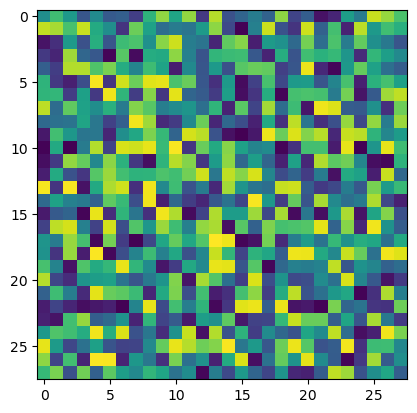

In [2]:
plt.imshow(torch.randint(0, 256, (1,28*28)).reshape(28,28))

In [3]:
W1_i = (torch.rand((64,784)).float() - 0.5)*2
b1_i = (torch.rand((64,1)).float() - 0.5)*2

W2_i = (torch.rand((10,64)).float() - 0.5)*2
b2_i = (torch.rand((10,1)).float() - 0.5)*2

In [20]:
mnist_vector = torch.randint(0, 256, (28*28,1)).float()/256
mnist_vector_rotated = torch.randint(0, 256, (28*28,1)).float()/256

def NN(x, thetas):
    W1, b1, W2, b2 = deflatten(thetas, get_shapes([W1_i, b1_i, W2_i,b2_i]))
    out = W2 @ torch.nn.LeakyReLU()(W1 @ x + b1) + b2
    return out

# Funzione che definisce la varietà: sfera unitaria centrata in 0
def g(thetas):
    NN1 = NN(mnist_vector, thetas)
    NN2 = NN(mnist_vector_rotated, thetas)
    Delta_NN = NN1 - NN2
    norm = Delta_NN.norm()**2
    return norm # sfera unitaria

# Gradiente di f
def dg(thetas):
    gradient = grad(g)(thetas)
    return gradient #+ 1e-5*(gradient.norm()==0)

def flatten(weights_list):
    flatten_weights = []
    for weight in weights_list:
        flatten_weights.append(weight.flatten())
        
    return np.concatenate(flatten_weights)

def deflatten(weights_flat, shapes):
    weigths_list = []
    shape_counter = 0
    for shape in shapes:
        weight = torch.Tensor(weights_flat[shape_counter: shape_counter + np.prod(shape)])
        shape_counter = shape_counter + np.prod(shape)
        
        weigths_list.append(weight.reshape(shape))
            
    return weigths_list

def get_shapes(weights_list):
    shapes = []
    for weight in weights_list:
        shapes.append(weight.shape)
    return(shapes)

# Classe LevelSetManifold già implementata sopra
class LevelSetManifold(geoopt.manifolds.Manifold):
    
    ndim = 1
    name = "Caste"
    
    def __init__(self, f, df, lr_proj = 1):
        super().__init__()
        self.f = f
        self.df = df
        self.lr_proj = lr_proj

    def _check_point_on_manifold(self, x, atol=1e-7, rtol=1e-7):
        return torch.abs(self.f(x)) < atol

    def _check_vector_on_tangent(self, x, u, atol=1e-7, rtol=1e-7):
        grad_f = self.df(x)
        return torch.abs(u @ grad_f).sum() < atol
    
    def projx(self,x):
        if self._check_point_on_manifold(x):
            return x
        for r in range(50):
            x = self.single_projx(x)
#             print("g: ", self.f(x))
#             print("dg: ", self.df(x).norm())
            if r == 49:
                print(f"Retraction applied {r + 1} times")
            if self._check_point_on_manifold(x):
                print(f"Retraction applied {r + 1} times")
                break
        return x
    
    def single_projx(self, x):
        grad_f = self.df(x)
        f_val = self.f(x)
        return x - self.lr_proj*(f_val / grad_f.norm()**2 * grad_f)

    def proju(self, x, u):
        grad_f = self.df(x)
        return u - (u @ grad_f) / grad_f.norm()**2 * grad_f

    def inner(self, x, u, v=None):
        if v is None:
            v = u
        return (u * v).sum()

    def expmap(self, x, u):
        return self.retr(x, u)

    def egrad2rgrad(self, x, u):
        return self.proju(x, u)

    def retr(self, x, u):
        x_new = x + u
        return self.projx(x_new)









g:  tensor(2144.3240, grad_fn=<PowBackward0>)
############ Landing phase #############
Retraction applied 19 times
0 g:  4.8974925448419526e-08
Landed :)



############## Training phase ################
Retraction applied 15 times
Epoch 1 Loss: 20.624500274658203 g(theta): 7e-08
Retraction applied 18 times
Epoch 2 Loss: 3.4688143730163574 g(theta): 4e-08
Epoch 3 Loss: 2.3841830625315197e-06 g(theta): 4e-08
Epoch 4 Loss: 2.3841830625315197e-06 g(theta): 4e-08
Epoch 5 Loss: 2.3841830625315197e-06 g(theta): 4e-08
Epoch 6 Loss: 2.3841830625315197e-06 g(theta): 4e-08
Epoch 7 Loss: 2.3841830625315197e-06 g(theta): 4e-08
Epoch 8 Loss: 2.3841830625315197e-06 g(theta): 4e-08
Epoch 9 Loss: 2.3841830625315197e-06 g(theta): 4e-08
Epoch 10 Loss: 2.3841830625315197e-06 g(theta): 4e-08



Punto finale: Parameter on Caste manifold containing:
Parameter(ManifoldParameter([ 0.3198, -0.7492, -0.0248,  ..., -0.3371,  0.3099,
                    0.1405], requires_grad=True))
Appartiene alla varietà?

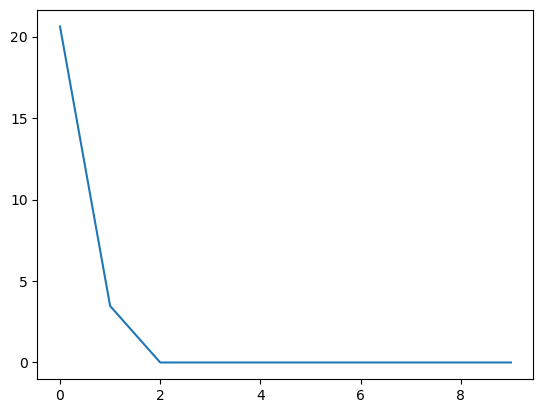

In [19]:
# Creiamo la varietà
manifold = LevelSetManifold(g, dg, 1)
# Test del parametro manifold

theta = flatten([W1_i, b1_i, W2_i, b2_i])
theta = geoopt.ManifoldParameter(theta , manifold=manifold)


# Proiettiamo il parametro iniziale sulla varietà
print("\n\n\n\n\n")
# print("99", "Primo theta: ",  theta.data)
print("g: ", g(theta))
print("############ Landing phase #############")
for i in range(10):
    theta.data = manifold.projx(theta.data)
    if i%5 == 0:
        print(i, "g: ", g(theta).item())

    if g(theta)< 1e-7:
        print("Landed :)")
        break
        
    
print("\n\n")

# Verifica che il parametro iniziale appartenga alla varietà
assert manifold._check_point_on_manifold(theta.data), "Il punto iniziale non è sulla varietà"

# Definiamo una loss function: minimizziamo la norma quadrata
def loss_fn(mnist_vector, theta):
    return torch.nn.CrossEntropyLoss()(NN(mnist_vector, theta).T, torch.Tensor([2]).long()  )  # Ad esempio, massimizzare la componente x[0]

# Ottimizzatore Riemanniano
optimizer = RiemannianSGD([theta], lr=0.005)

# Ciclo di ottimizzazione
g_during_train = []
loss_history = []
print("############## Training phase ################")
for epoch in range(10):
    optimizer.zero_grad()
    loss = loss_fn(mnist_vector, theta)
    loss.backward()
    optimizer.step()
    if epoch%1 == 0:
        print("Epoch",  epoch + 1, 
              "Loss:", loss.item(),
#               "theta:", theta.data[1].item(),
              "g(theta):", round(float(g(theta).data.numpy()),8))
    loss_history.append(loss.item())
    g_during_train.append(g(theta).data.numpy())
# plt.plot(g_during_train)
plt.plot(loss_history)
print("\n\n")

# Risultato finale
print("Punto finale:", theta)
print("Appartiene alla varietà?", manifold._check_point_on_manifold(theta))

In [13]:
torch.leakyrelu

AttributeError: module 'torch' has no attribute 'leakyrelu'

In [ ]:
input = NN(mnist_vector, theta)
# target = torch.Tensor([5])


print(input)